In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import ipywidgets as widgets
import sys, os, io, string, shutil, math
from hublib.ui import Submit
import hublib.use
%use boost-1.62.0-mpich2-1.3-gnu-4.7.2
import numpy as np
import re
import time
from threading import Thread
from io import StringIO

style = {'description_width': 'initial'}

<IPython.core.display.Javascript object>

In [2]:
e_np = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const inside NP:',
    style=style,
)
e_np

BoundedFloatText(value=78.5, description='Dielectric const inside NP:', max=78.5, min=2.0, step=0.1, style=DescriptionStyle(description_width='initial'))

In [3]:
e_out = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const outside NP:',
    style=style,
)
e_out

BoundedFloatText(value=78.5, description='Dielectric const outside NP:', max=78.5, min=2.0, step=0.1, style=DescriptionStyle(description_width='initial'))

In [4]:
pion = widgets.Dropdown(
    options={'1(monovalent)': 1, '2(divalent)': 2, '3(trivalent)': 3},
    value=1,
    description="Positive Ion Valency (z)",
    style=style
)
pion

Dropdown(description='Positive Ion Valency (z)', options={'1(monovalent)': 1, '2(divalent)': 2, '3(trivalent)': 3}, style=DescriptionStyle(description_width='initial'), value=1)

In [5]:
c_out = widgets.BoundedFloatText(
    value=0.0,
    min=0.0,
    max=0.4,
    step=0.1,
    description='salt concentration outside:',
    style=style
)
c_out

BoundedFloatText(value=0.0, description='salt concentration outside:', max=0.4, step=0.1, style=DescriptionStyle(description_width='initial'))

In [6]:
np_radius = widgets.BoundedFloatText(
    value=2.6775,
    min=2,
    max=5,
    step=0.001,
    description='Nanoparticle Radius (nm):',
    style=style
)
np_radius

BoundedFloatText(value=2.6775, description='Nanoparticle Radius (nm):', max=5.0, min=2.0, step=0.001, style=DescriptionStyle(description_width='initial'))

In [7]:
np_charge = widgets.BoundedFloatText(
    value=-60,
    min=-300,
    max=-30,
    step=-1,
    description='Nanoparticle Charge:',
    style=style
)
np_charge

BoundedFloatText(value=-60.0, description='Nanoparticle Charge:', max=-30.0, min=-300.0, step=-1.0, style=DescriptionStyle(description_width='initial'))

In [8]:
steps = widgets.BoundedIntText(
    value=5000,
    min=5000,
    max=5000000,
    step=100000,
    description='Simulation Steps:',
    style=style,
)
steps

BoundedIntText(value=5000, description='Simulation Steps:', max=5000000, min=5000, step=100000, style=DescriptionStyle(description_width='initial'))

In [9]:
label_style = "style='background-color: #DCDCDC; font-size:200; padding: 5px'"
def make_label(name, desc=""):
    lval = '<p  %s %s>%s</p>' % (desc, label_style, name)
    return widgets.HTML(lval)

plabel = make_label('Physical', '')
clabel = make_label('Computing', '')

In [10]:
image_html = widgets.HTML(
    value='<img src="../webcontent/images/overview.jpg" style="width: 500px"/>',
)
image_html

HTML(value='<img src="../webcontent/images/overview.jpg" style="width: 500px"/>')

In [23]:
about=widgets.Textarea(
    value='The Nanosphere Electrostatics Lab empowers users to simulate the self-assembly of ions near a spherically shaped nanoparticle, and extract the effective electrostatic properties.',
    placeholder='',
    layout={'height': '50px','width': '100%'},
    disabled=True
)
about

Textarea(value='The Nanosphere Electrostatics Lab empowers users to simulate the self-assembly of ions near a spherically shaped nanoparticle, and extract the effective electrostatic properties.', disabled=True, layout=Layout(height='50px', width='100%'), placeholder='')

In [12]:
def clear_All():
    progressBar
    progressBar.value=int(0)
    plt.clf()  # clear old plot

In [13]:

runFlag=False
working_dir=""
parameter_append=""
sim_bigin=False

def callExe(s):
    global runFlag, working_dir, parameter_append, sim_bigin
    clear_All()
    
    e_np_value = e_np.value
    e_out_value = e_out.value
    pion_value = pion.value
    c_out_value = c_out.value
    np_radius_value = np_radius.value
    np_charge_value = np_charge.value
    sim_steps_value = steps.value
    walltime = 10
    total_processors = 1
    
    #Adding standard outputs to string to be sent to output widget callback function
    parameter_append= "Epsilon inside NP is"+ str(e_np_value)+"\n"
    parameter_append= parameter_append + "Epsilon outside NP is"+ str(e_out_value)+"\n"
    parameter_append= parameter_append + "Positive Ion Valency is"+ str(pion_value)+"\n"
    parameter_append= parameter_append + "Salt concentration outside is"+ str(c_out_value)+"\n"
    parameter_append= parameter_append + "Sphere(NP) radius is"+ str(np_radius_value)+"\n"
    parameter_append= parameter_append + "NP charge is"+ str(np_charge_value)+"\n"
    parameter_append= parameter_append + "simulation time step is"+ str(sim_steps_value)+"\n"
    parameter_append= parameter_append + "Requested walltime is "+ str(walltime)+"\n"
    parameter_append= parameter_append + "Requested total_processors are "+ str(total_processors)+"\n"
    
    shutil.rmtree('datafiles',True)
    if not os.path.exists('datafiles'):
        os.makedirs('datafiles')
    shutil.rmtree('outfiles',True)
    if not os.path.exists('outfiles'):
        os.makedirs('outfiles')
    shutil.rmtree('verifiles',True)
    if not os.path.exists('verifiles'):
        os.makedirs('verifiles')

    # forcing OpenMP thread size, comment when deploying
    os.environ["OMP_NUM_THREADS"] = "1"

    runName=''
    
    #computing parameters are scaled here.
    hiteqm_P =int(sim_steps_value * 0.1);
    writedata_U =int(sim_steps_value * 0.1);
    writedensity_W =int(sim_steps_value * 0.1);
    extra_compute_X = int(sim_steps_value * 0.01);
    moviefreq_F = int(sim_steps_value * 0.01);
    cpmd_verify_Y = int(sim_steps_value * 0.1); 
    
    #submit_str = '--local -p "@@Vin=%d:%d in %d" /apps/pegtut/current/examples/capacitor_voltage/sim1.py  --Vin=@@Vin' % (vin.value[0], vin.value[1], steps.value)
    
    paraList = ' -a ' + str(np_radius_value) + ' -b ' + str(14.28) + ' -e ' + str(e_np_value) + ' -E ' + str(e_out_value) \
    + ' -V ' + str(np_charge_value) + ' -v ' + str(pion_value) + ' -g ' + str(132) + ' -m ' + str(6) + ' -t ' \
    + str(0.001) + ' -s ' + str(10000) + ' -p ' + str(100) + ' -f ' + str(10) + ' -M ' + str(6) + ' -T ' \
    + str(0.001) + ' -k ' + str(0.0025) + ' -q ' + str(0.001) + ' -L ' + str(5) + ' -l ' + str(5) \
    + ' -S ' + str(sim_steps_value) + ' -P ' + str(hiteqm_P) + ' -F ' + str(moviefreq_F) \
    + ' -X ' + str(extra_compute_X) + ' -U ' + str(writedata_U) + ' -Y ' + str(cpmd_verify_Y) \
    + ' -W ' + str(writedensity_W) + ' -B ' + str(0.025) + ' -I ' + 'false'
    
    runFlag=True
    sim_bigin=True
    
    #starting a thread for on the fly density plot
    #t2 = Thread(target=iterative_density_plot)
    #t2.start()
    
    try:
        #rname = s.make_rname(e_np_value, e_out_value, pion_value, c_out_value, np_radius_value, np_charge_value, sim_steps_value)
         
        submit_str = '--local mpirun -np 1 ./np_electrostatics_lab' + paraList
        #submit_str = '--local pwd'
        s.run(runName, submit_str)
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of np_electrostatics_lab')
        sys.stderr.write(str(e))
        sys.exit(1)
    
    time.sleep(1)
    runFlag = False
    #t2.join()
        
    
        
  

In [14]:
# after the run finished, optionally do something
# with the output
def plot_data(s, rdir):
    #We ignore rdir because submit puts non-parametric runs in the current directory
    # When caching is enabled, they get put in a chached directory and rdit is always used. 
    progressBar.value=int(100)
    plt.clf()  # clear old plot
    plt.figure('Distribution of positive ions near the nanoparticle surface')
    plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
    plt.ylabel('Density(M)', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        density_profile = np.loadtxt(working_dir + 'outfiles/density_profile.dat')
    except:
        sys.stderr.write('Can not find the positive density results file')
        sys.exit(1)
        
    x = density_profile[:,0]
    y = density_profile[:,1]
    yrr = density_profile[:,2]
    plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    
    plt.show()

In [15]:
def iterative_density_plot():
    global runFlag, working_dir
    preFileName=''
    while runFlag:
        list_of_files = os.listdir(working_dir + "datafiles")
        print('File List: '+ str(list_of_files))
        
        if list_of_files:
            fileName=max(list_of_files,key=extract_number)
            if preFileName != fileName:
                preFileName = fileName
                density_plot(fileName)
            print('doing this  '+ fileName )
        time.sleep(0.1)

def extract_number(f):
    s = re.findall("\d+$",f)
    return (int(s[0]) if s else -1,f)

In [16]:
def density_plot(filepathname):
    plt.clf()  # clear old plot
    timeStep = int(re.search(r'\d+', filepathname).group())
    plt.figure('Distribution of positive ions near the nanoparticle surface at time step = ' + str(timeStep))
    plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
    plt.ylabel('Density(M)', fontsize=10)
    print(filepathname)
    # our simulation writes to datafiles -> _den_******.dat
    #try:
    density_profile = np.loadtxt(working_dir + 'datafiles/'+ filepathname)
    #except:
    #    sys.stderr.write('Can not find the positive density results file')
    #   sys.exit(1)

    x = density_profile[:,0]
    y = density_profile[:,1]
    plt.polt(x,y,'r-')

    plt.show()
    

In [17]:
in_wrapper = False
saved_data = ""
def stdoutput_handler(buffer):
    global in_wrapper, saved_data, parameter_append, sim_bigin
    output = []
    
    if sim_bigin:
        output.append(parameter_append)
        sim_bigin = False
   
    data = buffer.split('\n')
    last = len(data) - 1
    
    for i, line in enumerate(data):
        if in_wrapper:
            if line.startswith('####_Density_Profile_Wrapper_Over_#'):
                in_wrapper = False
            else:
                saved_data += line
                if line == '' or (i != last):
                    saved_data += '\n'
            continue        
        if line.startswith('=PROGRESS=>'):
            percent = (line.split('=PROGRESS=>'))[1]
            progressBar.value=int(percent)
        elif line.startswith('####_Density_Profile_Wrapper_#'):
            print(saved_data)
            in_wrapper = True
            saved_data = ""
        else:
            output.append(line)
    return '\n'.join(output)

<IPython.core.display.Javascript object>


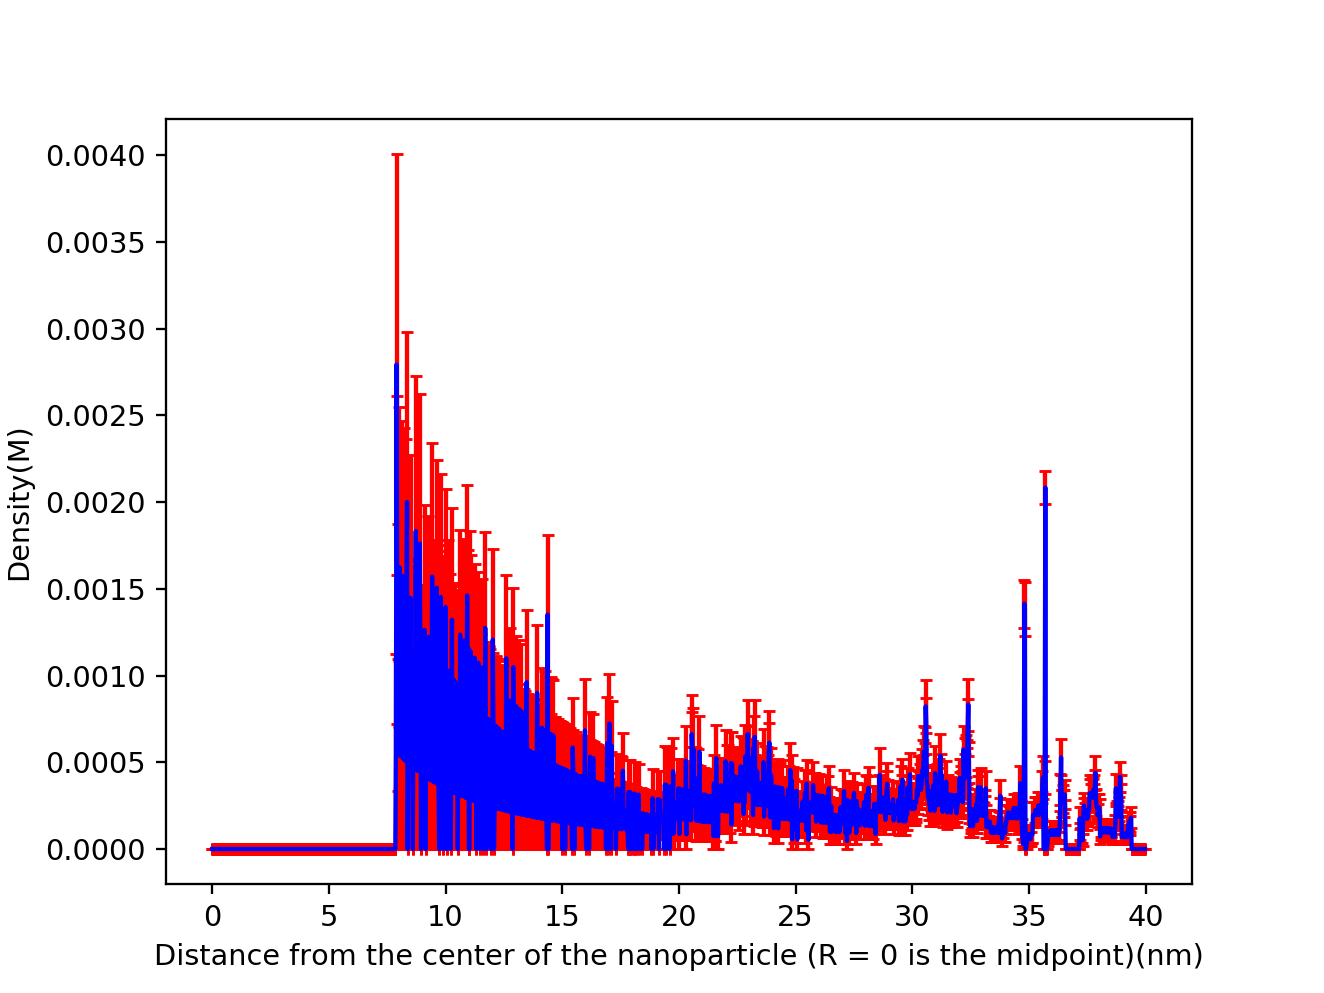

In [18]:
# we want the plot to go here, so create an empty one initially
plt.figure('Distribution of positive ions near the nanoparticle surface')
plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
plt.ylabel('Density(M)', fontsize=10)
plt.show()

In [19]:
#Submit(start_func=callExe, done_func=plot_data, cachename='SubmitTest1')
Submit(start_func=callExe, done_func=plot_data, outcb=stdoutput_handler)


VBox(children=(Button(button_style='success', description='Run', style=ButtonStyle(), tooltip='Run Simulation'),), layout=Layout(flex_flow='column', justify_content='flex-start', width='auto'))

In [20]:
progressBar=widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Progress:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
    layout={'width': '100%'},
)
progressBar

IntProgress(value=0, description='Progress:', layout=Layout(width='100%'))